In [1]:
# ipython
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("white")
import glob
import json
import os
import sys
import shutil

def save_fig(ax, title="", pdfname="plot.pdf"):
    if title != "":
        ax.set_title(title)
    ax.get_figure().savefig(pdfname, bbox_inches="tight")
   

In [2]:
def read_json(x):
    with open(x) as xfp:
        return json.load(xfp)

def clean_up(users, images):

    dd = images.groupby(by="uuid").apply(lambda x: all(x["rating"] == 1) or len(x) <50).reset_index()
    # filter out participants who rated all = 1, or who rated less than 50 images
    #dx = images.groupby(by="uuid").apply(lambda x: len(x)).reset_index()
    #d(dx)
    dd = dd.rename(columns={0: "excluded"})

    dimages = pd.merge(images, dd, left_on="uuid", right_on="uuid")
    dimages = dimages[dimages["excluded"] != True]
    
    dimages["filename_and_fake"] = dimages["filename"] + dimages["fake"].apply(str)
    dusers = pd.merge(dd, users, left_on="uuid", right_on="uuid")
    old = len(dusers)
    dusers = dusers[dusers["excluded"] != True]

    print(f"excluded users: {old - len(dusers)}")
    return dusers, dimages


import scipy.stats as st

def calculate_stats(images):
    def confidence(x):
        x = x["rating"]
        # estimate the confidence interval # To be checked
        y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
        return  (y[1] - y[0]) / 2

    def rating_dist(x):
        #print(x)
        res = {
            "num_ratings": 0
        }
        hist = {}

        for rating in x["rating"].values:
            hist[rating] = hist.get(rating, 0) + 1
            res["num_ratings"] += 1
        for r in range(1,6):
            res[f"count_{r}"] = hist.get(r, 0)
        return pd.Series(res)

    mos = images[["filename_and_fake", "fake", "rating"]].groupby(by="filename_and_fake").mean().reset_index().rename(columns={"rating": "mos"})
    ci = images[["filename_and_fake", "rating"]].groupby(by="filename_and_fake").apply(confidence).reset_index().rename(columns={0: "ci"})
    std = images[["filename_and_fake", "rating"]].groupby(by="filename_and_fake").std().reset_index().rename(columns={"rating": "std"})
    
    dist = images[["filename_and_fake", "rating"]].groupby(by="filename_and_fake").apply(rating_dist).reset_index() #.rename(columns={0: "ci"})

    stats = pd.merge(std, pd.merge(pd.merge(ci, mos), dist))
    stats["filename"] = stats["filename_and_fake"].apply(lambda x: x[0:-1])  # last char is "fake" --> 0,1
    return stats


def make_plots(basedir, testname):
    users = pd.DataFrame(read_json(sorted(list(glob.glob(basedir + "/*_users.json")))[-1]))
    images = pd.DataFrame(read_json(sorted(list(glob.glob(basedir + "/*_images.json")))[-1]))
    
    users, images = clean_up(users, images)
    d(images.head())
    d(users.head())
    sns.set(rc={'figure.figsize':(6,3)})
    sns.set_style("white")
    num_users = len(users)
    num_ratings = len(images)
    ax = sns.boxplot(images.groupby(by="filename_and_fake").count().reset_index()["_id"])
    
    save_fig(ax, f"test #2: {testname}: ratins per image; users={num_users}; ratings={num_ratings}", f"ratings_per_image_{testname}.pdf")
    plt.show()
    
    ax = sns.countplot(images["rating"])
    save_fig(ax, f"test #2: {testname}: counts per rating; users={num_users}; ratings={num_ratings}", f"counts_per_rating_{testname}.pdf")
    plt.show()
    
    di = images.groupby(by="filename_and_fake").mean().reset_index()[["filename_and_fake", "rating"]]
    ax = sns.distplot(di["rating"])

    save_fig(ax, f"test #2: {testname}: mean rating dist; users={num_users}; ratings={num_ratings}", f"mean_rating_dist_{testname}.pdf")

    return calculate_stats(images)


excluded users: 2


,_id,fake,likes,views,filename,uuid,rating,date,__v,excluded,filename_and_fake
0,{'$oid': '61efe1df327020001174064a'},1,896,1800,static/images/pixabay_first50k/medium/ski-1036...,937d57b3-01b2-4757-8805-74365aa1103f,3,{'$date': '2022-01-25T11:41:19.491Z'},0,False,static/images/pixabay_first50k/medium/ski-1036...
1,{'$oid': '61efe1e1327020001174064f'},0,23,124,static/images/500px_cc0/medium/252755949_It_co...,937d57b3-01b2-4757-8805-74365aa1103f,3,{'$date': '2022-01-25T11:41:21.581Z'},0,False,static/images/500px_cc0/medium/252755949_It_co...
2,{'$oid': '61efe1e33270200011740654'},1,63,133,static/images/pixabay_first50k/medium/spring-4...,937d57b3-01b2-4757-8805-74365aa1103f,2,{'$date': '2022-01-25T11:41:23.908Z'},0,False,static/images/pixabay_first50k/medium/spring-4...
3,{'$oid': '61efe1e63270200011740659'},1,51,151,static/images/500px_cc0/medium/258564947_Phace...,937d57b3-01b2-4757-8805-74365aa1103f,4,{'$date': '2022-01-25T11:41:26.097Z'},0,False,static/images/500px_cc0/medium/258564947_Phace...
4,{'$oid': '61efe1e8327020001174065e'},0,600,363213,static/images/pixabay_first50k/medium/horses-1...,937d57b3-01b2-4757-8805-74365aa1103f,4,{'$date': '2022-01-25T11:41:28.128Z'},0,False,static/images/pixabay_first50k/medium/horses-1...


,uuid,excluded,_id,image_list,fake_likes_list,image_index,query_params,date,__v,age_range,browser_agent,computer_type,eye_quality,room_quality,screen_size
0,0670e8c7-fe9f-41d2-a2e7-03c8d7a8681f,False,{'$oid': '61f13bb9327020001175818a'},[static/images/pixabay_first50k/medium/kermit-...,"[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...",200,,{'$date': '2022-01-26T12:16:57.556Z'},0,30 to 39,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:7...,Laptop,Excellent(5),Alone in a Quiet Room,1536x750
2,10ecd7cc-a78b-46af-9a7e-3f9c3359f2d9,False,{'$oid': '61f135b1327020001175098c'},[static/images/500px_cc0/medium/232783277_goin...,"[1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...",200,,{'$date': '2022-01-26T11:51:13.965Z'},0,30 to 39,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Desktop,Excellent(5),Alone in a Quiet Room,2560x1232
3,10f098c0-5b9e-48ff-b8b0-77ac5cbc9b83,False,{'$oid': '61f134ea327020001174eab8'},[static/images/pixabay_first50k/medium/cloud-4...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ...",200,,{'$date': '2022-01-26T11:47:54.405Z'},0,30 to 39,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Desktop,Excellent(5),Alone in a Quiet Room,1920x937
4,15067654-7dfe-4ad3-baeb-b33c82f03e16,False,{'$oid': '61f134ad327020001174e525'},[static/images/pixabay_first50k/medium/perfume...,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",170,,{'$date': '2022-01-26T11:46:53.555Z'},0,30 to 39,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Laptop,Excellent(5),Alone in a Quiet Room,1440x821
5,1559fcad-4575-4dea-9067-fee84bd6c83c,False,{'$oid': '61f134d5327020001174e8b7'},[static/images/pixabay_first50k/medium/soap-bu...,"[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...",200,,{'$date': '2022-01-26T11:47:33.871Z'},0,50 to 59,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,Laptop,Good(4),Alone in a Quiet Room,1426x754


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


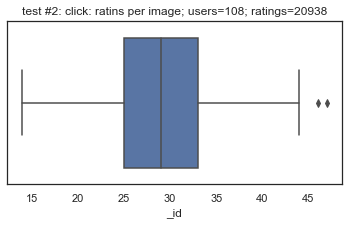

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


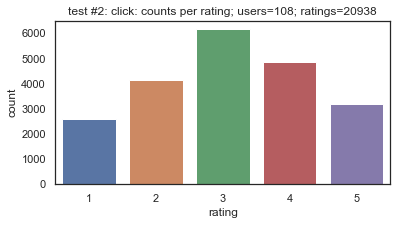

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.121721,0.374000,0.0,2.270270,37,11,11,11,2,2,static/images/500px_cc0/medium/100327907_some_...
1,static/images/500px_cc0/medium/100327907_some_...,1.214247,0.399113,1.0,2.342105,38,12,9,12,2,3,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.288911,0.464702,0.0,2.375000,32,10,9,7,3,3,static/images/500px_cc0/medium/1003502191_Flat...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.261980,0.489345,1.0,2.500000,28,7,8,8,2,3,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.183216,0.406449,0.0,2.800000,35,5,9,13,4,4,static/images/500px_cc0/medium/1011015162_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
713,static/images/pixabay_first50k/medium/woman-53...,1.346406,0.512145,1.0,2.206897,29,12,7,5,2,3,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.272418,0.564159,0.0,3.000000,22,4,3,6,7,2,static/images/pixabay_first50k/medium/women-12...
715,static/images/pixabay_first50k/medium/women-12...,1.296148,0.523526,1.0,3.000000,26,5,4,5,10,2,static/images/pixabay_first50k/medium/women-12...
716,static/images/pixabay_first50k/medium/women-81...,1.037126,0.356265,0.0,3.428571,35,2,3,13,12,5,static/images/pixabay_first50k/medium/women-81...


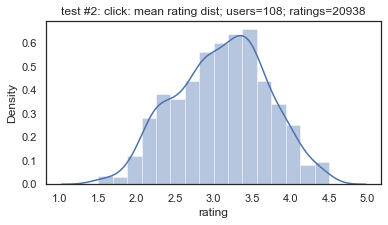

In [4]:
stats_click = make_plots("export_clickworker", "click")

d(stats_click)
stats_click.to_csv("stats_click_test_2.csv", index=False)

In [32]:
print(
    stats_click["num_ratings"].min(),
    np.median(stats_click["num_ratings"]),
    stats_click["num_ratings"].max(),
)

14 29.0 47


In [65]:
print(
    stats_click["mos"].min().round(2), 
    np.median(stats_click["mos"]).round(2),
    stats_click["mos"].max().round(2)
)

1.5 3.14 4.5


In [5]:
fakes = stats_click[stats_click["fake"] == 1]
d(fakes)

,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
1,static/images/500px_cc0/medium/100327907_some_...,1.214247,0.399113,1.0,2.342105,38,12,9,12,2,3,static/images/500px_cc0/medium/100327907_some_...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.261980,0.489345,1.0,2.500000,28,7,8,8,2,3,static/images/500px_cc0/medium/1003502191_Flat...
5,static/images/500px_cc0/medium/1011015162_Anem...,1.158794,0.410890,1.0,2.696970,33,5,10,11,4,3,static/images/500px_cc0/medium/1011015162_Anem...
7,static/images/500px_cc0/medium/1011015165_Anem...,1.134147,0.408904,1.0,2.062500,32,13,9,6,3,1,static/images/500px_cc0/medium/1011015165_Anem...
9,static/images/500px_cc0/medium/1011015217_Anem...,1.050638,0.345336,1.0,2.631579,38,4,16,10,6,2,static/images/500px_cc0/medium/1011015217_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
709,static/images/pixabay_first50k/medium/woman-35...,1.322876,0.546056,1.0,3.400000,25,2,5,6,5,7,static/images/pixabay_first50k/medium/woman-35...
711,static/images/pixabay_first50k/medium/woman-38...,1.046606,0.422733,1.0,2.153846,26,10,4,10,2,0,static/images/pixabay_first50k/medium/woman-38...
713,static/images/pixabay_first50k/medium/woman-53...,1.346406,0.512145,1.0,2.206897,29,12,7,5,2,3,static/images/pixabay_first50k/medium/woman-53...
715,static/images/pixabay_first50k/medium/women-12...,1.296148,0.523526,1.0,3.000000,26,5,4,5,10,2,static/images/pixabay_first50k/medium/women-12...


In [6]:
nonfakes = stats_click[stats_click["fake"] == 0]
d(nonfakes)

,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.121721,0.374000,0.0,2.270270,37,11,11,11,2,2,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.288911,0.464702,0.0,2.375000,32,10,9,7,3,3,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.183216,0.406449,0.0,2.800000,35,5,9,13,4,4,static/images/500px_cc0/medium/1011015162_Anem...
6,static/images/500px_cc0/medium/1011015165_Anem...,1.247219,0.483621,0.0,2.000000,28,14,5,6,1,2,static/images/500px_cc0/medium/1011015165_Anem...
8,static/images/500px_cc0/medium/1011015217_Anem...,1.138221,0.368968,0.0,2.384615,39,9,14,11,2,3,static/images/500px_cc0/medium/1011015217_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
708,static/images/pixabay_first50k/medium/woman-35...,1.406132,0.556247,0.0,3.148148,27,4,5,8,3,7,static/images/pixabay_first50k/medium/woman-35...
710,static/images/pixabay_first50k/medium/woman-38...,1.080123,0.445853,0.0,2.200000,25,9,5,8,3,0,static/images/pixabay_first50k/medium/woman-38...
712,static/images/pixabay_first50k/medium/woman-53...,1.305609,0.527347,0.0,2.230769,26,10,7,4,3,2,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.272418,0.564159,0.0,3.000000,22,4,3,6,7,2,static/images/pixabay_first50k/medium/women-12...


In [7]:
# check like views vs appeal
likes_views = pd.read_json("../images/likes_views.json")
likes_views = likes_views[likes_views["real"]]
likes_views["image_path"] = likes_views["image_path"].apply(
    lambda x: 
        "static/images/" + x.replace("/images/", "/medium/")
)
d(likes_views)
print(likes_views["image_path"].values[0])
d(nonfakes)
lva = pd.merge(likes_views, nonfakes, left_on="image_path", right_on="filename")
d(lva)

,image_path,likes,views,real
0,static/images/pixabay_first50k/medium/duck-493...,1,83,True
1,static/images/pixabay_first50k/medium/frog-338...,3,251,True
2,static/images/pixabay_first50k/medium/gulls-84...,2,589,True
3,static/images/pixabay_first50k/medium/swan-fig...,1,292,True
4,static/images/pixabay_first50k/medium/fragrapa...,3,410,True
...,...,...,...,...
354,static/images/500px_cc0/medium/252756875_cornf...,23,151,True
355,static/images/500px_cc0/medium/139228225_Sunse...,158,828,True
356,static/images/500px_cc0/medium/302137935_Cherr...,32,99,True
357,static/images/500px_cc0/medium/242215175_Guy_e...,19,91,True


static/images/pixabay_first50k/medium/duck-4934652.jpg


,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.121721,0.374000,0.0,2.270270,37,11,11,11,2,2,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.288911,0.464702,0.0,2.375000,32,10,9,7,3,3,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.183216,0.406449,0.0,2.800000,35,5,9,13,4,4,static/images/500px_cc0/medium/1011015162_Anem...
6,static/images/500px_cc0/medium/1011015165_Anem...,1.247219,0.483621,0.0,2.000000,28,14,5,6,1,2,static/images/500px_cc0/medium/1011015165_Anem...
8,static/images/500px_cc0/medium/1011015217_Anem...,1.138221,0.368968,0.0,2.384615,39,9,14,11,2,3,static/images/500px_cc0/medium/1011015217_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
708,static/images/pixabay_first50k/medium/woman-35...,1.406132,0.556247,0.0,3.148148,27,4,5,8,3,7,static/images/pixabay_first50k/medium/woman-35...
710,static/images/pixabay_first50k/medium/woman-38...,1.080123,0.445853,0.0,2.200000,25,9,5,8,3,0,static/images/pixabay_first50k/medium/woman-38...
712,static/images/pixabay_first50k/medium/woman-53...,1.305609,0.527347,0.0,2.230769,26,10,7,4,3,2,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.272418,0.564159,0.0,3.000000,22,4,3,6,7,2,static/images/pixabay_first50k/medium/women-12...


,image_path,likes,views,real,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/pixabay_first50k/medium/duck-493...,1,83,True,static/images/pixabay_first50k/medium/duck-493...,1.203859,0.508345,0.0,2.833333,24,4,5,8,5,2,static/images/pixabay_first50k/medium/duck-493...
1,static/images/pixabay_first50k/medium/frog-338...,3,251,True,static/images/pixabay_first50k/medium/frog-338...,1.153916,0.487256,0.0,2.875000,24,5,1,11,6,1,static/images/pixabay_first50k/medium/frog-338...
2,static/images/pixabay_first50k/medium/gulls-84...,2,589,True,static/images/pixabay_first50k/medium/gulls-84...,1.110684,0.439372,0.0,3.185185,27,3,3,9,10,2,static/images/pixabay_first50k/medium/gulls-84...
3,static/images/pixabay_first50k/medium/swan-fig...,1,292,True,static/images/pixabay_first50k/medium/swan-fig...,1.069867,0.432129,0.0,3.230769,26,1,6,8,8,3,static/images/pixabay_first50k/medium/swan-fig...
4,static/images/pixabay_first50k/medium/fragrapa...,3,410,True,static/images/pixabay_first50k/medium/fragrapa...,0.947872,0.382854,0.0,3.461538,26,1,2,10,10,3,static/images/pixabay_first50k/medium/fragrapa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,static/images/500px_cc0/medium/252756875_cornf...,23,151,True,static/images/500px_cc0/medium/252756875_cornf...,1.002460,0.381315,0.0,2.172414,29,8,11,8,1,1,static/images/500px_cc0/medium/252756875_cornf...
355,static/images/500px_cc0/medium/139228225_Sunse...,158,828,True,static/images/500px_cc0/medium/139228225_Sunse...,0.966092,0.354365,0.0,4.000000,31,0,2,8,9,12,static/images/500px_cc0/medium/139228225_Sunse...
356,static/images/500px_cc0/medium/302137935_Cherr...,32,99,True,static/images/500px_cc0/medium/302137935_Cherr...,1.156418,0.448412,0.0,3.178571,28,3,4,9,9,3,static/images/500px_cc0/medium/302137935_Cherr...
357,static/images/500px_cc0/medium/242215175_Guy_e...,19,91,True,static/images/500px_cc0/medium/242215175_Guy_e...,1.056827,0.468571,0.0,2.454545,22,5,6,7,4,0,static/images/500px_cc0/medium/242215175_Guy_e...


In [29]:
lva[lva["real"]]

,image_path,likes,views,real,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/pixabay_first50k/medium/duck-493...,1,83,True,static/images/pixabay_first50k/medium/duck-493...,1.203859,0.508345,0.0,2.833333,24,4,5,8,5,2,static/images/pixabay_first50k/medium/duck-493...
1,static/images/pixabay_first50k/medium/frog-338...,3,251,True,static/images/pixabay_first50k/medium/frog-338...,1.153916,0.487256,0.0,2.875000,24,5,1,11,6,1,static/images/pixabay_first50k/medium/frog-338...
2,static/images/pixabay_first50k/medium/gulls-84...,2,589,True,static/images/pixabay_first50k/medium/gulls-84...,1.110684,0.439372,0.0,3.185185,27,3,3,9,10,2,static/images/pixabay_first50k/medium/gulls-84...
3,static/images/pixabay_first50k/medium/swan-fig...,1,292,True,static/images/pixabay_first50k/medium/swan-fig...,1.069867,0.432129,0.0,3.230769,26,1,6,8,8,3,static/images/pixabay_first50k/medium/swan-fig...
4,static/images/pixabay_first50k/medium/fragrapa...,3,410,True,static/images/pixabay_first50k/medium/fragrapa...,0.947872,0.382854,0.0,3.461538,26,1,2,10,10,3,static/images/pixabay_first50k/medium/fragrapa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,static/images/500px_cc0/medium/252756875_cornf...,23,151,True,static/images/500px_cc0/medium/252756875_cornf...,1.002460,0.381315,0.0,2.172414,29,8,11,8,1,1,static/images/500px_cc0/medium/252756875_cornf...
355,static/images/500px_cc0/medium/139228225_Sunse...,158,828,True,static/images/500px_cc0/medium/139228225_Sunse...,0.966092,0.354365,0.0,4.000000,31,0,2,8,9,12,static/images/500px_cc0/medium/139228225_Sunse...
356,static/images/500px_cc0/medium/302137935_Cherr...,32,99,True,static/images/500px_cc0/medium/302137935_Cherr...,1.156418,0.448412,0.0,3.178571,28,3,4,9,9,3,static/images/500px_cc0/medium/302137935_Cherr...
357,static/images/500px_cc0/medium/242215175_Guy_e...,19,91,True,static/images/500px_cc0/medium/242215175_Guy_e...,1.056827,0.468571,0.0,2.454545,22,5,6,7,4,0,static/images/500px_cc0/medium/242215175_Guy_e...


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='likes', ylabel='Density'>

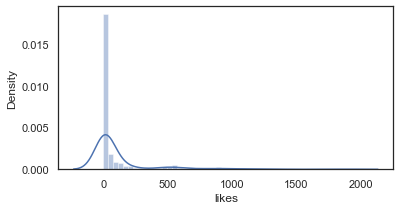

In [8]:
sns.distplot(lva["likes"])

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='views', ylabel='Density'>

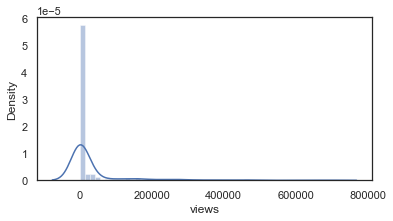

In [9]:
sns.distplot(lva["views"])

In [89]:
#likes, views mos
lva["ratio"] = lva["likes"] / lva["views"]
lva["loglikes"] = np.log(lva["likes"] + 1)
lva["logviews"] = np.log(lva["views"] + 1)
lva["logratio"] = lva["loglikes"] / lva["logviews"]
lva["loginvratio"] = lva["logviews"] / (1 + lva["loglikes"])

like_view_metrics = []

for c in ["likes", "views", "ratio", "loglikes", "logviews", "logratio", "loginvratio"]:
    p = lva[["mos", c]].corr(method="pearson")["mos"].values[1]
    k = lva[["mos", c]].corr(method="kendall")["mos"].values[1]
    s = lva[["mos", c]].corr(method="spearman")["mos"].values[1]
    like_view_metrics.append(
        {
            "cmp":  c,
            "p": p,
            "k": k,
            "s": s
        }
    )
    
dlike_view_metrics = pd.DataFrame(like_view_metrics)

print(dlike_view_metrics.sort_values(by="p", ascending=False).round(3).to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
        cmp &      p &      k &      s \\
\midrule
   loglikes &  0.432 &  0.286 &  0.414 \\
   logviews &  0.384 &  0.233 &  0.347 \\
      likes &  0.329 &  0.286 &  0.414 \\
   logratio &  0.300 &  0.216 &  0.317 \\
      views &  0.262 &  0.233 &  0.347 \\
      ratio & -0.001 & -0.045 & -0.071 \\
loginvratio & -0.230 & -0.150 & -0.222 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3446780/4267623412.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dlike_view_metrics.sort_values(by="p", ascending=False).round(3).to_latex(index=False))


<AxesSubplot:xlabel='loglikes', ylabel='mos'>

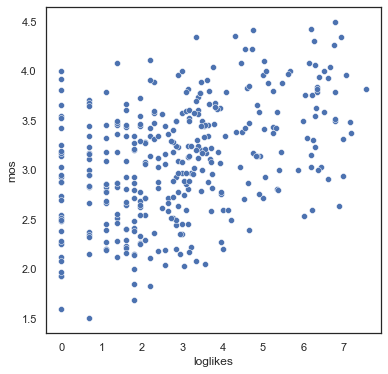

In [90]:
sns.scatterplot(x="loglikes", y="mos", data=lva)

<AxesSubplot:xlabel='logviews', ylabel='mos'>

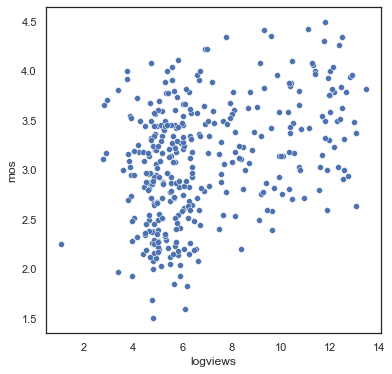

In [91]:
sns.scatterplot(x="logviews", y="mos", data=lva)

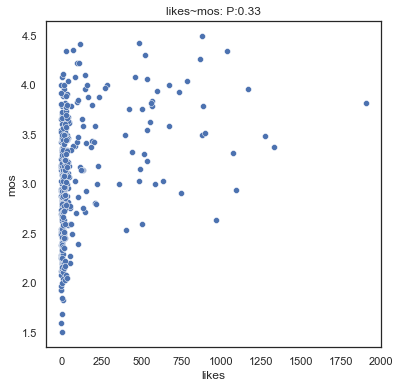

In [10]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

ax = sns.scatterplot(x="likes", y="mos", data=lva)

p = lva[["likes", "mos"]].corr()["likes"][1]
save_fig(ax, title=f"likes~mos: P:{p.round(2)}", pdfname="likes_mos_scatter.pdf")

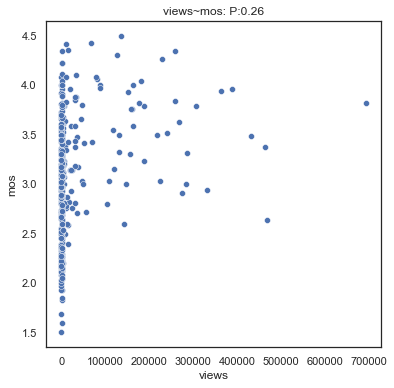

In [11]:
ax = sns.scatterplot(x="views", y="mos", data=lva)
p = lva[["views", "mos"]].corr()["views"][1]

save_fig(ax, title=f"views~mos: P:{p.round(2)}", pdfname="views_mos_scatter.pdf")

In [12]:
dm = pd.merge(fakes, nonfakes, left_on="filename", right_on="filename", suffixes=("_fakes", "_nonfakes"))
d(dm)

,filename_and_fake_fakes,std_fakes,ci_fakes,fake_fakes,mos_fakes,num_ratings_fakes,count_1_fakes,count_2_fakes,count_3_fakes,count_4_fakes,...,std_nonfakes,ci_nonfakes,fake_nonfakes,mos_nonfakes,num_ratings_nonfakes,count_1_nonfakes,count_2_nonfakes,count_3_nonfakes,count_4_nonfakes,count_5_nonfakes
0,static/images/500px_cc0/medium/100327907_some_...,1.214247,0.399113,1.0,2.342105,38,12,9,12,2,...,1.121721,0.374000,0.0,2.270270,37,11,11,11,2,2
1,static/images/500px_cc0/medium/1003502191_Flat...,1.261980,0.489345,1.0,2.500000,28,7,8,8,2,...,1.288911,0.464702,0.0,2.375000,32,10,9,7,3,3
2,static/images/500px_cc0/medium/1011015162_Anem...,1.158794,0.410890,1.0,2.696970,33,5,10,11,4,...,1.183216,0.406449,0.0,2.800000,35,5,9,13,4,4
3,static/images/500px_cc0/medium/1011015165_Anem...,1.134147,0.408904,1.0,2.062500,32,13,9,6,3,...,1.247219,0.483621,0.0,2.000000,28,14,5,6,1,2
4,static/images/500px_cc0/medium/1011015217_Anem...,1.050638,0.345336,1.0,2.631579,38,4,16,10,6,...,1.138221,0.368968,0.0,2.384615,39,9,14,11,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,static/images/pixabay_first50k/medium/woman-35...,1.322876,0.546056,1.0,3.400000,25,2,5,6,5,...,1.406132,0.556247,0.0,3.148148,27,4,5,8,3,7
355,static/images/pixabay_first50k/medium/woman-38...,1.046606,0.422733,1.0,2.153846,26,10,4,10,2,...,1.080123,0.445853,0.0,2.200000,25,9,5,8,3,0
356,static/images/pixabay_first50k/medium/woman-53...,1.346406,0.512145,1.0,2.206897,29,12,7,5,2,...,1.305609,0.527347,0.0,2.230769,26,10,7,4,3,2
357,static/images/pixabay_first50k/medium/women-12...,1.296148,0.523526,1.0,3.000000,26,5,4,5,10,...,1.272418,0.564159,0.0,3.000000,22,4,3,6,7,2


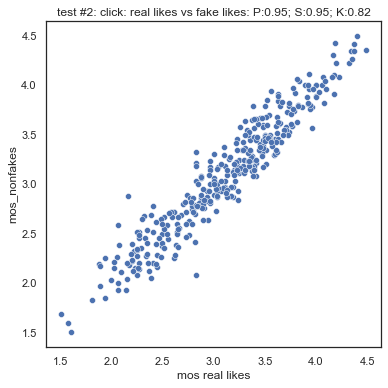

In [34]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

ax = sns.scatterplot(
    x="mos_fakes", 
    y="mos_nonfakes", 
    #hue="num_ratings_fakes", 
    data=dm
)
ax.set_xlabel("mos fake likes")
ax.set_xlabel("mos real likes")

p = dm[["mos_fakes", "mos_nonfakes"]].corr(method="pearson")["mos_fakes"].values[1]
k = dm[["mos_fakes", "mos_nonfakes"]].corr(method="kendall")["mos_fakes"].values[1]
s = dm[["mos_fakes", "mos_nonfakes"]].corr(method="spearman")["mos_fakes"].values[1]

save_fig(
    ax, 
    f"test #2: click: real likes vs fake likes: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", 
    "real_likes_vs_fake_likes_click.pdf"
)


In [14]:
from scipy import stats
def paired_t_test(col1, col2, data):
    s, p = stats.ttest_rel(data[col1], data[col2])
    print(f"paired t test with {col1}~{col2}")
    if p > 0.05:
        print("same average")
    else:
        print("not the same average")
paired_t_test("mos_fakes", "mos_nonfakes", dm)     

paired t test with mos_fakes~mos_nonfakes
same average


In [15]:
# evaluate correlation with prev test, that was not including likes-views
dclick = pd.read_csv("../evaluation_image_appeal_test_1/stats_clickworker.csv")
d(dclick)

dmm = pd.merge(dm, dclick, left_on="filename", right_on="filename", suffixes=("", "_click"))
d(dmm)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0
...,...,...,...,...,...,...,...,...,...,...
1053,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6
1054,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2
1055,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1
1056,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2


,filename_and_fake_fakes,std_fakes,ci_fakes,fake_fakes,mos_fakes,num_ratings_fakes,count_1_fakes,count_2_fakes,count_3_fakes,count_4_fakes,...,count_5_nonfakes,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.214247,0.399113,1.0,2.342105,38,12,9,12,2,...,2,1.092398,0.450920,2.880000,25,4,3,11,6,1
1,static/images/500px_cc0/medium/1003502191_Flat...,1.261980,0.489345,1.0,2.500000,28,7,8,8,2,...,3,1.099766,0.475575,2.869565,23,2,7,8,4,2
2,static/images/500px_cc0/medium/1011015162_Anem...,1.158794,0.410890,1.0,2.696970,33,5,10,11,4,...,4,0.978093,0.403737,2.960000,25,1,7,11,4,2
3,static/images/500px_cc0/medium/1011015165_Anem...,1.134147,0.408904,1.0,2.062500,32,13,9,6,3,...,2,1.144703,0.427439,2.000000,30,14,6,7,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.050638,0.345336,1.0,2.631579,38,4,16,10,6,...,3,0.888523,0.415842,2.500000,20,2,9,6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,static/images/pixabay_first50k/medium/woman-35...,1.322876,0.546056,1.0,3.400000,25,2,5,6,5,...,7,1.105013,0.517162,3.800000,20,1,1,5,7,6
351,static/images/pixabay_first50k/medium/woman-38...,1.046606,0.422733,1.0,2.153846,26,10,4,10,2,...,0,1.228321,0.592032,2.789474,19,3,5,6,3,2
352,static/images/pixabay_first50k/medium/woman-53...,1.346406,0.512145,1.0,2.206897,29,12,7,5,2,...,2,1.114741,0.573147,2.352941,17,4,6,5,1,1
353,static/images/pixabay_first50k/medium/women-12...,1.296148,0.523526,1.0,3.000000,26,5,4,5,10,...,2,1.063219,0.448958,3.000000,24,2,5,10,5,2


In [48]:
metric_values = []

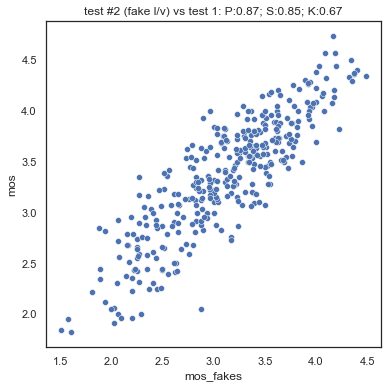

In [49]:
ax = sns.scatterplot(
    x="mos_fakes", 
    y="mos", 
#    hue="num_ratings_fakes", 
    data=dmm
)
p = dmm[["mos_fakes", "mos"]].corr(method="pearson")["mos_fakes"].values[1]
k = dmm[["mos_fakes", "mos"]].corr(method="kendall")["mos_fakes"].values[1]
s = dmm[["mos_fakes", "mos"]].corr(method="spearman")["mos_fakes"].values[1]

metric_values.append(
{
    "what": "test #2 click",
    "cmp": "fake likes vs test1",
    "p": p,
    "k": k,
    "s": s
}
)

save_fig(
    ax, 
    f"test #2 (fake l/v) vs test 1: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", 
    "fake_lv_vs_test1.pdf"
)


In [17]:

paired_t_test("mos_fakes", "mos", dmm)     

paired t test with mos_fakes~mos
not the same average


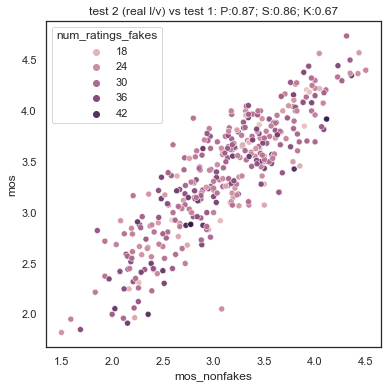

In [50]:
ax = sns.scatterplot(x="mos_nonfakes", y="mos", hue="num_ratings_fakes", data=dmm)
p = dmm[["mos_nonfakes", "mos"]].corr(method="pearson")["mos_nonfakes"].values[1]
k = dmm[["mos_nonfakes", "mos"]].corr(method="kendall")["mos_nonfakes"].values[1]
s = dmm[["mos_nonfakes", "mos"]].corr(method="spearman")["mos_nonfakes"].values[1]

metric_values.append(
{
    "what": "test #2 click",
    "cmp": "real likes vs test1",
    "p": p,
    "k": k,
    "s": s
}
)


save_fig(ax, f"test 2 (real l/v) vs test 1: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", "real_lv_vs_test1.pdf")


In [19]:
paired_t_test("mos_nonfakes", "mos", dmm)     

paired t test with mos_nonfakes~mos
not the same average


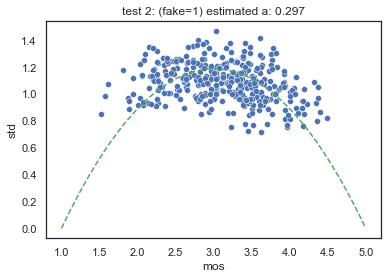

In [20]:
def sos_plot(df, title=""):
    assert("mos" in df.columns)
    assert("std" in df.columns)
    
    sns.set(rc={'figure.figsize':(6,4)})
    sns.set_style("white")

    ax = sns.scatterplot(x="mos", y="std", data=df)
    x_data = df["mos"].values
    y_data = df["std"].replace(np.NaN, 0).values

    from scipy.optimize import curve_fit

    def fitting_function(x, a):
        return (x - 1) * (x - 5) * (-a)

    popt, pcov = curve_fit(fitting_function, x_data, y_data) 


    x = np.linspace(1, 5, 100)
    ax.plot(x, fitting_function(x, *popt), 'g--')
    ax.set_title(title + f" estimated a: {popt[0].round(3)}")
    return ax

save_fig(sos_plot(stats_click[stats_click["fake"] == 1], "test 2: (fake=1)"), pdfname="test_2_fake_sos.pdf")

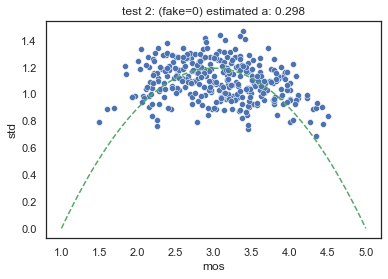

In [21]:

save_fig(sos_plot(stats_click[stats_click["fake"] == 0], "test 2: (fake=0)"), pdfname="test_2_nonfake_sos.pdf")

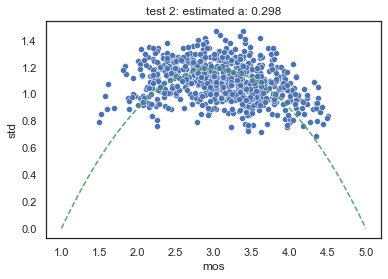

In [22]:

save_fig(sos_plot(stats_click, "test 2:"), pdfname="test_2_sos.pdf")

excluded users: 0


,_id,fake,likes,views,filename,uuid,rating,date,__v,excluded,filename_and_fake
0,{'$oid': '622f305a30ffdf001113040e'},0,747,274800,static/images/pixabay_first50k/medium/water-22...,0a63c6ec-394b-44d5-8da2-0b701590c9f8,4,{'$date': '2022-03-14T12:08:58.427Z'},0,False,static/images/pixabay_first50k/medium/water-22...
1,{'$oid': '622f308830ffdf0011130413'},1,20,72,static/images/500px_cc0/medium/302137879_Cherr...,0a63c6ec-394b-44d5-8da2-0b701590c9f8,2,{'$date': '2022-03-14T12:09:44.969Z'},0,False,static/images/500px_cc0/medium/302137879_Cherr...
2,{'$oid': '622f308d30ffdf0011130418'},0,4,103,static/images/500px_cc0/medium/254033919_fores...,0a63c6ec-394b-44d5-8da2-0b701590c9f8,3,{'$date': '2022-03-14T12:09:49.418Z'},0,False,static/images/500px_cc0/medium/254033919_fores...
3,{'$oid': '622f309030ffdf001113041d'},0,2,533,static/images/pixabay_first50k/medium/nature-2...,0a63c6ec-394b-44d5-8da2-0b701590c9f8,5,{'$date': '2022-03-14T12:09:52.465Z'},0,False,static/images/pixabay_first50k/medium/nature-2...
4,{'$oid': '622f309630ffdf0011130422'},1,1335,2758,static/images/pixabay_first50k/medium/apple-48...,0a63c6ec-394b-44d5-8da2-0b701590c9f8,2,{'$date': '2022-03-14T12:09:58.329Z'},0,False,static/images/pixabay_first50k/medium/apple-48...


,uuid,excluded,_id,image_list,fake_likes_list,image_index,query_params,date,__v,age_range,browser_agent,computer_type,eye_quality,room_quality,screen_size
0,098865c8-3058-4b8c-8eb8-aacbc78cc8b7,False,{'$oid': '6230574a30ffdf0011135cc1'},[static/images/pixabay_first50k/medium/old-113...,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...",718,,{'$date': '2022-03-15T09:07:22.039Z'},0,25 to 29,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Desktop,Good(4),Alone in a Quiet Room,1920x1080
1,0a63c6ec-394b-44d5-8da2-0b701590c9f8,False,{'$oid': '622f300930ffdf0011130408'},[static/images/pixabay_first50k/medium/water-2...,"[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...",718,,{'$date': '2022-03-14T12:07:37.071Z'},0,25 to 29,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Laptop,Good(4),Alone in a Quiet Room,1920x1080
2,2631d666-bc8b-41e5-b0da-ab300fdafa07,False,{'$oid': '6234844330ffdf001113f7d7'},[static/images/pixabay_first50k/medium/meerkat...,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...",718,,{'$date': '2022-03-18T13:08:19.675Z'},0,30 to 39,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Laptop,Fair(3),Alone in a Quiet Room,1920x1080
3,2e29422e-eb86-4add-8a74-c4fe3fd23bee,False,{'$oid': '6232f86330ffdf001113bf67'},[static/images/500px_cc0/medium/291131203_Anci...,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, ...",718,,{'$date': '2022-03-17T08:59:15.092Z'},0,40 to 49,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Laptop,Good(4),Alone in a Quiet Room,1920x1080
4,31d3de7f-d05b-454e-b15e-484b5287a4b3,False,{'$oid': '62319bf130ffdf0011137900'},[static/images/pixabay_first50k/medium/morning...,"[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",718,,{'$date': '2022-03-16T08:12:33.305Z'},0,30 to 39,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Laptop,Good(4),Alone in a Quiet Room,1920x1008


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


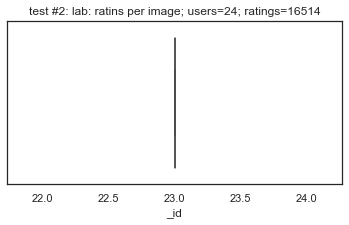

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


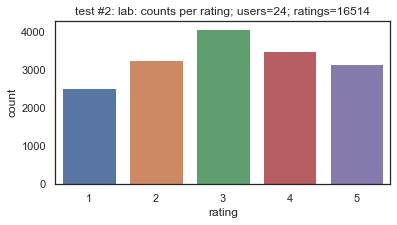

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.040675,0.450022,0.0,2.086957,23,9,5,7,2,0,static/images/500px_cc0/medium/100327907_some_...
1,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,0,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,0.0,3.478261,23,1,3,8,6,5,static/images/500px_cc0/medium/1003502191_Flat...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,5,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.300654,0.562445,0.0,2.652174,23,5,7,4,5,2,static/images/500px_cc0/medium/1011015162_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
713,static/images/pixabay_first50k/medium/woman-53...,1.260529,0.545094,1.0,2.956522,23,2,8,6,3,4,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.036870,0.448376,0.0,3.434783,23,0,5,7,7,4,static/images/pixabay_first50k/medium/women-12...
715,static/images/pixabay_first50k/medium/women-12...,0.902347,0.390204,1.0,3.782609,23,0,2,6,10,5,static/images/pixabay_first50k/medium/women-12...
716,static/images/pixabay_first50k/medium/women-81...,1.222322,0.528572,0.0,3.695652,23,1,2,9,2,9,static/images/pixabay_first50k/medium/women-81...


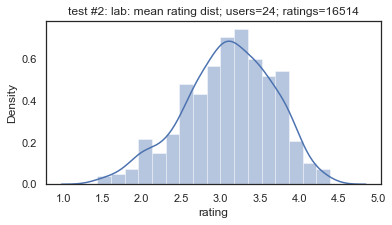

In [35]:
# checkout lab test

stats_lab2 = make_plots("lab_test_2/", "lab")

d(stats_lab2)
stats_lab2.to_csv("stats_lab_test_2.csv", index=False)

In [61]:
stats_lab2

,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.040675,0.450022,0.0,2.086957,23,9,5,7,2,0,static/images/500px_cc0/medium/100327907_some_...
1,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,0,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,0.0,3.478261,23,1,3,8,6,5,static/images/500px_cc0/medium/1003502191_Flat...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,5,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.300654,0.562445,0.0,2.652174,23,5,7,4,5,2,static/images/500px_cc0/medium/1011015162_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
713,static/images/pixabay_first50k/medium/woman-53...,1.260529,0.545094,1.0,2.956522,23,2,8,6,3,4,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.036870,0.448376,0.0,3.434783,23,0,5,7,7,4,static/images/pixabay_first50k/medium/women-12...
715,static/images/pixabay_first50k/medium/women-12...,0.902347,0.390204,1.0,3.782609,23,0,2,6,10,5,static/images/pixabay_first50k/medium/women-12...
716,static/images/pixabay_first50k/medium/women-81...,1.222322,0.528572,0.0,3.695652,23,1,2,9,2,9,static/images/pixabay_first50k/medium/women-81...


In [64]:
print(
    stats_lab2["mos"].min().round(2), 
    np.median(stats_lab2["mos"]).round(2),
    stats_lab2["mos"].max().round(2)
)

1.43 3.13 4.39


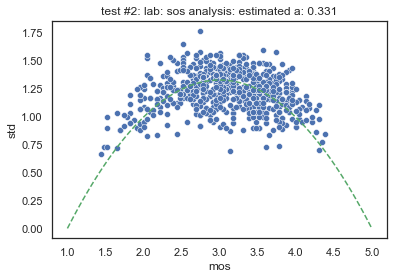

In [36]:


save_fig(sos_plot(stats_lab2, "test #2: lab: sos analysis:"), pdfname="lab_test_2_sos.pdf")

,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
1,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,0,static/images/500px_cc0/medium/100327907_some_...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,5,static/images/500px_cc0/medium/1003502191_Flat...
5,static/images/500px_cc0/medium/1011015162_Anem...,1.162660,0.502772,1.0,2.521739,23,5,6,9,1,2,static/images/500px_cc0/medium/1011015162_Anem...
7,static/images/500px_cc0/medium/1011015165_Anem...,0.875670,0.378668,1.0,1.695652,23,12,7,3,1,0,static/images/500px_cc0/medium/1011015165_Anem...
9,static/images/500px_cc0/medium/1011015217_Anem...,1.243163,0.537584,1.0,2.000000,23,10,8,2,1,2,static/images/500px_cc0/medium/1011015217_Anem...


,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.040675,0.450022,0.0,2.086957,23,9,5,7,2,0,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,0.0,3.478261,23,1,3,8,6,5,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.300654,0.562445,0.0,2.652174,23,5,7,4,5,2,static/images/500px_cc0/medium/1011015162_Anem...
6,static/images/500px_cc0/medium/1011015165_Anem...,1.167748,0.504972,0.0,2.000000,23,10,7,3,2,1,static/images/500px_cc0/medium/1011015165_Anem...
8,static/images/500px_cc0/medium/1011015217_Anem...,0.936734,0.405074,0.0,1.826087,23,10,9,2,2,0,static/images/500px_cc0/medium/1011015217_Anem...


,filename_and_fake_fakes,std_fakes,ci_fakes,fake_fakes,mos_fakes,num_ratings_fakes,count_1_fakes,count_2_fakes,count_3_fakes,count_4_fakes,...,std_nonfakes,ci_nonfakes,fake_nonfakes,mos_nonfakes,num_ratings_nonfakes,count_1_nonfakes,count_2_nonfakes,count_3_nonfakes,count_4_nonfakes,count_5_nonfakes
0,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,...,1.040675,0.450022,0.0,2.086957,23,9,5,7,2,0
1,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,...,1.122884,0.485572,0.0,3.478261,23,1,3,8,6,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.162660,0.502772,1.0,2.521739,23,5,6,9,1,...,1.300654,0.562445,0.0,2.652174,23,5,7,4,5,2
3,static/images/500px_cc0/medium/1011015165_Anem...,0.875670,0.378668,1.0,1.695652,23,12,7,3,1,...,1.167748,0.504972,0.0,2.000000,23,10,7,3,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.243163,0.537584,1.0,2.000000,23,10,8,2,1,...,0.936734,0.405074,0.0,1.826087,23,10,9,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,static/images/pixabay_first50k/medium/woman-35...,1.543826,0.667600,1.0,3.260870,23,4,4,5,2,...,1.429503,0.618163,0.0,3.043478,23,5,3,5,6,4
355,static/images/pixabay_first50k/medium/woman-38...,1.364427,0.590022,1.0,2.956522,23,4,5,6,4,...,1.455533,0.629420,0.0,2.869565,23,4,8,3,3,5
356,static/images/pixabay_first50k/medium/woman-53...,1.260529,0.545094,1.0,2.956522,23,2,8,6,3,...,1.445998,0.625296,0.0,3.000000,23,5,3,7,3,5
357,static/images/pixabay_first50k/medium/women-12...,0.902347,0.390204,1.0,3.782609,23,0,2,6,10,...,1.036870,0.448376,0.0,3.434783,23,0,5,7,7,4


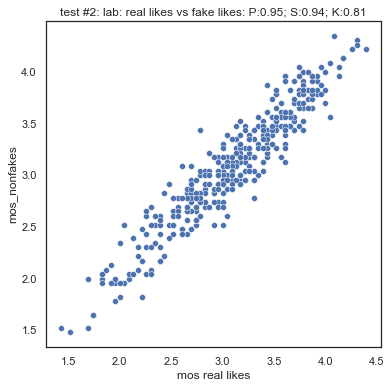

In [51]:
# fakes

fakes = stats_lab2[stats_lab2["fake"] == 1]
d(fakes.head())

# nonfakes
nonfakes = stats_lab2[stats_lab2["fake"] == 0]
d(nonfakes.head())

dm = pd.merge(fakes, nonfakes, left_on="filename", right_on="filename", suffixes=("_fakes", "_nonfakes"))
d(dm)

sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

ax = sns.scatterplot(
    x="mos_fakes", 
    y="mos_nonfakes", 
    #hue="num_ratings_fakes", 
    data=dm
)
ax.set_xlabel("mos fake likes")
ax.set_xlabel("mos real likes")

p = dm[["mos_fakes", "mos_nonfakes"]].corr(method="pearson")["mos_fakes"].values[1]
k = dm[["mos_fakes", "mos_nonfakes"]].corr(method="kendall")["mos_fakes"].values[1]
s = dm[["mos_fakes", "mos_nonfakes"]].corr(method="spearman")["mos_fakes"].values[1]




save_fig(
    ax, 
    f"test #2: lab: real likes vs fake likes: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", 
    "real_likes_vs_fake_likes_lab.pdf"
)



,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...
1056,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9
1057,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3
1058,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5
1059,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6


,filename_and_fake_fakes,std_fakes,ci_fakes,fake_fakes,mos_fakes,num_ratings_fakes,count_1_fakes,count_2_fakes,count_3_fakes,count_4_fakes,...,count_5_nonfakes,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,...,0,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,...,5,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.162660,0.502772,1.0,2.521739,23,5,6,9,1,...,2,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,0.875670,0.378668,1.0,1.695652,23,12,7,3,1,...,1,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.243163,0.537584,1.0,2.000000,23,10,8,2,1,...,0,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,static/images/pixabay_first50k/medium/woman-35...,1.543826,0.667600,1.0,3.260870,23,4,4,5,2,...,4,1.420726,0.573844,3.461538,26,3,4,6,4,9
355,static/images/pixabay_first50k/medium/woman-38...,1.364427,0.590022,1.0,2.956522,23,4,5,6,4,...,5,1.292097,0.511137,2.851852,27,4,9,4,7,3
356,static/images/pixabay_first50k/medium/woman-53...,1.260529,0.545094,1.0,2.956522,23,2,8,6,3,...,5,1.280625,0.528616,3.160000,25,3,4,9,4,5
357,static/images/pixabay_first50k/medium/women-12...,0.902347,0.390204,1.0,3.782609,23,0,2,6,10,...,4,1.174079,0.474221,3.461538,26,1,5,7,7,6


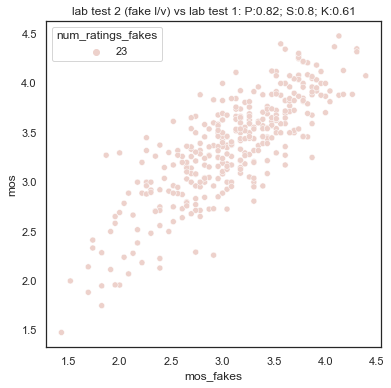

In [52]:
# evaluate correlation with prev lab test, that was not including likes-views
dlab1 = pd.read_csv("../evaluation_image_appeal_test_1/stats_lab_test_1.csv")
d(dlab1)

dmm = pd.merge(dm, dlab1, left_on="filename", right_on="filename", suffixes=("", "_lab1"))
d(dmm)

ax = sns.scatterplot(x="mos_fakes", y="mos", hue="num_ratings_fakes", data=dmm)
p = dmm[["mos_fakes", "mos"]].corr(method="pearson")["mos_fakes"].values[1]
k = dmm[["mos_fakes", "mos"]].corr(method="kendall")["mos_fakes"].values[1]
s = dmm[["mos_fakes", "mos"]].corr(method="spearman")["mos_fakes"].values[1]


metric_values.append(
{
    "what": "test #2 lab",
    "cmp": "fake likes vs test1",
    "p": p,
    "k": k,
    "s": s
}
)



save_fig(ax, f"lab test 2 (fake l/v) vs lab test 1: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", "lab_test_2_fake_lv_vs_test1.pdf")



In [34]:
paired_t_test("mos_nonfakes", "mos", dmm)

paired t test with mos_nonfakes~mos
not the same average


In [35]:
paired_t_test("mos_nonfakes", "mos_fakes", dmm)

paired t test with mos_nonfakes~mos_fakes
same average


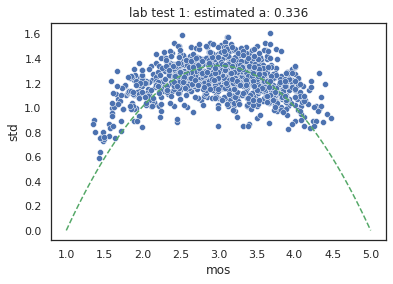

In [33]:

save_fig(sos_plot(dlab1, "lab test 1:"), pdfname="lab_test_1_sos.pdf")


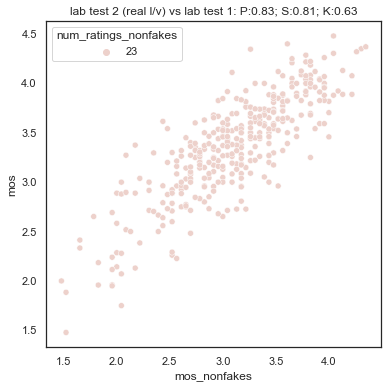

In [53]:
ax = sns.scatterplot(x="mos_nonfakes", y="mos", hue="num_ratings_nonfakes", data=dmm)
p = dmm[["mos_nonfakes", "mos"]].corr(method="pearson")["mos_nonfakes"].values[1]
k = dmm[["mos_nonfakes", "mos"]].corr(method="kendall")["mos_nonfakes"].values[1]
s = dmm[["mos_nonfakes", "mos"]].corr(method="spearman")["mos_nonfakes"].values[1]

metric_values.append(
{
    "what": "test #2 lab",
    "cmp": "real likes vs test1",
    "p": p,
    "k": k,
    "s": s
}
)


save_fig(ax, f"lab test 2 (real l/v) vs lab test 1: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", "lab_test_2_real_lv_vs_test1.pdf")



,filename_and_fake,std,ci,fake,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,filename
0,static/images/500px_cc0/medium/100327907_some_...,1.121721,0.374000,0.0,2.270270,37,11,11,11,2,2,static/images/500px_cc0/medium/100327907_some_...
1,static/images/500px_cc0/medium/100327907_some_...,1.214247,0.399113,1.0,2.342105,38,12,9,12,2,3,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.288911,0.464702,0.0,2.375000,32,10,9,7,3,3,static/images/500px_cc0/medium/1003502191_Flat...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.261980,0.489345,1.0,2.500000,28,7,8,8,2,3,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.183216,0.406449,0.0,2.800000,35,5,9,13,4,4,static/images/500px_cc0/medium/1011015162_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...
713,static/images/pixabay_first50k/medium/woman-53...,1.346406,0.512145,1.0,2.206897,29,12,7,5,2,3,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.272418,0.564159,0.0,3.000000,22,4,3,6,7,2,static/images/pixabay_first50k/medium/women-12...
715,static/images/pixabay_first50k/medium/women-12...,1.296148,0.523526,1.0,3.000000,26,5,4,5,10,2,static/images/pixabay_first50k/medium/women-12...
716,static/images/pixabay_first50k/medium/women-81...,1.037126,0.356265,0.0,3.428571,35,2,3,13,12,5,static/images/pixabay_first50k/medium/women-81...


,filename_and_fake,std_lab2,ci_lab2,fake_lab2,mos_lab2,num_ratings_lab2,count_1_lab2,count_2_lab2,count_3_lab2,count_4_lab2,...,ci_click,fake_click,mos_click,num_ratings_click,count_1_click,count_2_click,count_3_click,count_4_click,count_5_click,filename_click
0,static/images/500px_cc0/medium/100327907_some_...,1.040675,0.450022,0.0,2.086957,23,9,5,7,2,...,0.374000,0.0,2.270270,37,11,11,11,2,2,static/images/500px_cc0/medium/100327907_some_...
1,static/images/500px_cc0/medium/100327907_some_...,0.967863,0.418535,1.0,1.869565,23,11,5,6,1,...,0.399113,1.0,2.342105,38,12,9,12,2,3,static/images/500px_cc0/medium/100327907_some_...
2,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,0.0,3.478261,23,1,3,8,6,...,0.464702,0.0,2.375000,32,10,9,7,3,3,static/images/500px_cc0/medium/1003502191_Flat...
3,static/images/500px_cc0/medium/1003502191_Flat...,1.122884,0.485572,1.0,3.521739,23,1,3,7,7,...,0.489345,1.0,2.500000,28,7,8,8,2,3,static/images/500px_cc0/medium/1003502191_Flat...
4,static/images/500px_cc0/medium/1011015162_Anem...,1.300654,0.562445,0.0,2.652174,23,5,7,4,5,...,0.406449,0.0,2.800000,35,5,9,13,4,4,static/images/500px_cc0/medium/1011015162_Anem...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,static/images/pixabay_first50k/medium/woman-53...,1.260529,0.545094,1.0,2.956522,23,2,8,6,3,...,0.512145,1.0,2.206897,29,12,7,5,2,3,static/images/pixabay_first50k/medium/woman-53...
714,static/images/pixabay_first50k/medium/women-12...,1.036870,0.448376,0.0,3.434783,23,0,5,7,7,...,0.564159,0.0,3.000000,22,4,3,6,7,2,static/images/pixabay_first50k/medium/women-12...
715,static/images/pixabay_first50k/medium/women-12...,0.902347,0.390204,1.0,3.782609,23,0,2,6,10,...,0.523526,1.0,3.000000,26,5,4,5,10,2,static/images/pixabay_first50k/medium/women-12...
716,static/images/pixabay_first50k/medium/women-81...,1.222322,0.528572,0.0,3.695652,23,1,2,9,2,...,0.356265,0.0,3.428571,35,2,3,13,12,5,static/images/pixabay_first50k/medium/women-81...


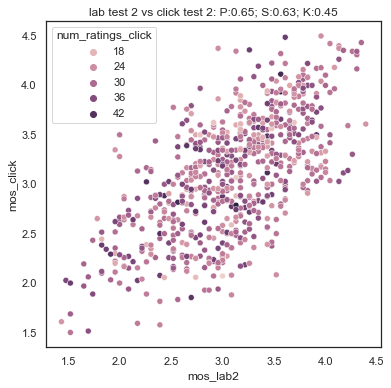

In [54]:
dclick = pd.read_csv("stats_click_test_2.csv")
d(dclick)

dxy = pd.merge(stats_lab2, dclick, left_on="filename_and_fake", right_on="filename_and_fake", suffixes=("_lab2", "_click"))
d(dxy)


ax = sns.scatterplot(x="mos_lab2", y="mos_click", hue="num_ratings_click", data=dxy)
p = dxy[["mos_lab2", "mos_click"]].corr(method="pearson")["mos_lab2"].values[1]
k = dxy[["mos_lab2", "mos_click"]].corr(method="kendall")["mos_lab2"].values[1]
s = dxy[["mos_lab2", "mos_click"]].corr(method="spearman")["mos_lab2"].values[1]

metric_values.append(
{
    "what": "test #2",
    "cmp": "lab vs click",
    "p": p,
    "k": k,
    "s": s
}
)



save_fig(ax, f"lab test 2 vs click test 2: P:{p.round(2)}; S:{s.round(2)}; K:{k.round(2)}", "lab_test_2_vs_click.pdf")





In [60]:
dmetric_global_eval = pd.DataFrame(metric_values)
print(dmetric_global_eval.sort_values(by="p", ascending=False).round(2).to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
         what &                 cmp &    p &    k &    s \\
\midrule
test \#2 click & real likes vs test1 & 0.87 & 0.67 & 0.86 \\
test \#2 click & fake likes vs test1 & 0.87 & 0.67 & 0.85 \\
  test \#2 lab & real likes vs test1 & 0.83 & 0.63 & 0.81 \\
  test \#2 lab & fake likes vs test1 & 0.82 & 0.61 & 0.80 \\
      test \#2 &        lab vs click & 0.65 & 0.45 & 0.63 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3446780/3348206642.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dmetric_global_eval.sort_values(by="p", ascending=False).round(2).to_latex(index=False))
